In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
%matplotlib inline

import random
import copy
from util import normalization

In [9]:
import warnings
warnings.filterwarnings('ignore')

X_train_gd = normalization(np.load('./data/feature/X_train_gd_nl.npy'))
X_train_gmd = normalization(np.load('./data/feature/X_train_gmd_nl.npy'))
X_train_gld = normalization(np.load('./data/feature/X_train_gld_nl.npy')) 

X_test_gd = normalization(np.load('./data/feature/X_test_gd_nl.npy'))
X_test_gmd = normalization(np.load('./data/feature/X_test_gmd_nl.npy'))
X_test_gld = normalization(np.load('./data/feature/X_test_gld_nl.npy'))

X_gd = np.concatenate((X_train_gd,X_test_gd))
X_gmd = np.concatenate((X_train_gmd,X_test_gmd))
X_gld = np.concatenate((X_train_gld,X_test_gld))
print(X_gd.shape,X_gmd.shape,X_gld.shape)

(11392, 512)


In [ ]:
y_train=open('./data/y_train.txt').read().split('\n')[:-1] 
y_train=[int(y) for y in y_train]
y_train=np.array(y_train)
y_train=y_train.reshape(y_train.shape[0],1)

y_test=open('./data/y_test.txt').read().split('\n')[:-1]   
y_test=[int(y) for y in y_test]
y_test = np.array(y_test)
y_test =y_test.reshape(y_test.shape[0],1)

y_train.shape, y_test.shape

In [ ]:
X_gd = np.concatenate((X_train_gd,X_test_gd))
X_gmd = np.concatenate((X_train_gmd,X_test_gmd))
X_gld = np.concatenate((X_train_gld,X_test_gld))

X_gd_all =np.copy(X_gd) 
X_gd_all =normalization(X_gd_all)
X_gd_all = torch.from_numpy(X_gd_all).type(torch.FloatTensor)

X_gmd_all =np.copy(X_gmd)   
X_gmd_all =normalization(X_gmd_all)
X_gmd_all = torch.from_numpy(X_gmd_all).type(torch.FloatTensor)

X_gld_all =np.copy(X_gld)  
X_gld_all =normalization(X_gld_all)
X_gld_all = torch.from_numpy(X_gld_all).type(torch.FloatTensor)


y_all =np.concatenate((y_train,y_test))   
y_all =torch.from_numpy(y_all).type(torch.FloatTensor)

X_gd_all.size(),X_gmd_all.size(),X_gld_all.size(),y_all.size()

In [44]:
class DGAClassifier(nn.Module):
#     def __init__(self,inp_size):
    def __init__(self,inp_size,inp_size_bak1,inp_size_bak2):
        super(DGAClassifier,self).__init__()
        #         self.att = nn.Linear(inp_size,inp_size)
        self.fc1 = nn.Linear(inp_size, 128)
        self.relu = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)
        self.out_act = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()
        
        self.multihead_attn = torch.nn.MultiheadAttention(embed_dim = inp_size, num_heads =8 )
        self.linear = nn.Linear(256,128)
        self.linear256 = nn.Linear(256,256)
        self.linear384 = nn.Linear(384,256)
        self.linear512 = nn.Linear(512,256)
    def forward(self, input_,input_gmd,input_gld):
#         print("__init__:input_",input_)
#         t = self.att(input_)
#         s = self.tanh(t)
        # GD+GMD+GLD
        gd_md,attn_output_weights = self.multihead_attn(input_gmd,input_,input_)
        gd_ld,attn_output_weights = self.multihead_attn(input_gld,input_,input_)
        gd_mld = torch.cat((gd_md,gd_ld,input_),1)   # 768
        gd_mld = self.linear384(gd_mld) 
        input_ = gd_mld
        # GD+GMD
        # input_gd_gmd,attn_output_weights = self.multihead_attn(input_gmd,input_,input_)  
        # input_ = torch.cat((input_gd_gmd,input_),1)
        # input_ = self.linear512(input_)

        # GD+GLD
#         input_gd_gld,attn_output_weights = self.multihead_attn(input_gld,input_,input_)  
#         input_ = torch.cat((input_gd_gld,input_),1)
#         input_ = self.linear384(input_)       
        # GD
#         input_,attn_output_weights = self.multihead_attn(input_,input_,input_)  
#         input_ = torch.cat((input_,input_),1)
#         input_ = self.linear256(input_)
        
        s = self.tanh(input_)       #s= torch.Size([batch_size, 128])  alpha= torch.Size([batch_size, 128])
        alpha = self.softmax(s)
        x = torch.mul(alpha,input_)
        a1 = self.fc1(x)
        h1 = self.relu(a1)
        dout = self.dout(h1)   # 损失率
        a2 = self.fc2(dout)
        h2 = self.relu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    
    def predict(self,x,x_gmd,x_gld): 
        #Apply softmax to output. 
        pred = self.forward(x,x_gmd,x_gld)
        ans = []
        #Pick the class with maximum weight
        for t in pred:
            if t<0.5:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)
    
    def predict_probability(self,x,x_gmd,x_gld):
        pred = self.forward(x,x_gmd,x_gld)
        ans = pred
        return torch.tensor(ans)
    
    def predict_probability2(self,x,x_gmd,x_gld):
        pred = self.forward(x,x_gmd,x_gld)
        pred_score = pred
        ans = []
        for t in pred:
            if t<0.5:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(pred_score),torch.tensor(ans)

In [13]:
def train_cv(model, X, X_gmd, X_gld, y, opt, criterion, batch_size=64): 
    model.train()
    losses = []
    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, :]
        x_gmd_batch = X_gmd[beg_i:beg_i + batch_size, :]
        x_gld_batch = X_gld[beg_i:beg_i + batch_size, :]
        
        y_batch = y[beg_i:beg_i + batch_size, :]
        x_batch = Variable(x_batch)
        x_gmd_batch = Variable(x_gmd_batch)
        x_gld_batch = Variable(x_gld_batch)
        y_batch = Variable(y_batch)

        opt.zero_grad()
        # (1) Forward
        y_hat = clf(x_batch, x_gmd_batch, x_gld_batch)
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    avg_loss=sum(losses)/len(losses)
    return losses,avg_loss

In [14]:
def avg(l):
    return sum(l)/len(l)
def compute_aupr(y,yhat):
    pre,rec,_ = precision_recall_curve(y,yhat)
    return auc(rec,pre)
def f1_score(precison, recall):
    try:
        return 2*precison*recall /(precison + recall)
    except:
        return 0.0

In [ ]:
fpr_list=[]
tpr_list=[]
aucs = []
avg_pre = []
aupr = []
acc = []
recal = []
cv = StratifiedKFold(n_splits=5)    
num_epochs = 30
fold_loss =[]
gmd_list = []
for i, (train,test) in enumerate(cv.split(X_gmd_all, y_all)):
    gmd_list.append((train,test))
gld_list = []
for i, (train,test) in enumerate(cv.split(X_gld_all, y_all)):
    gld_list.append((train,test))

print("start",'-'*100)
for i, (train,test) in enumerate(cv.split(X_gd_all, y_all)):

    clf = DGAClassifier(X_gd_all.size()[1],X_gmd_all.size()[1],X_gld_all.size()[1]) 
    opt = optim.Adam(clf.parameters(), lr=0.01, betas=(0.9, 0.999),weight_decay=1e-5)
    criterion = nn.BCELoss()
    
    e_losses = []
    for e in range(num_epochs):
        los,avg_loss = train_cv(clf,X_gd_all[train],X_gmd_all[train],X_gld_all[train],y_all[train],opt,criterion)   
        e_losses += [avg_loss]
        print ("Fold:%d Epoch:%d/%d Train loss:%f" %(i+1,e,num_epochs,avg_loss))
        
    fold_loss.append(e_losses)   
    # y_pred = clf.predict(X_gd_all[test], X_gmd_all[test], X_gld_all[test])
    y_pred_roc,y_pred = clf.predict_probability2(X_gd_all[test], X_gmd_all[test], X_gld_all[test])
    fpr,tpr,_= roc_curve(y_all[test],y_pred_roc)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    aucs.append(roc_auc_score(y_all[test],y_pred))
    recal.append(recall_score(y_all[test],y_pred))
    # print("Test accuracy:%f" %acc[-1])
    # print('\n')

avr_f1_score = f1_score(avg(avg_pre), avg(recal))

# print ("AUC:%f AUPR: %f Avg Pre: %f Acc: %f _f1_score: %f Recal:%f" %(avg(aucs),avg(aupr),avg(avg_pre),avg(acc),avr_f1_score,avg(recal)))

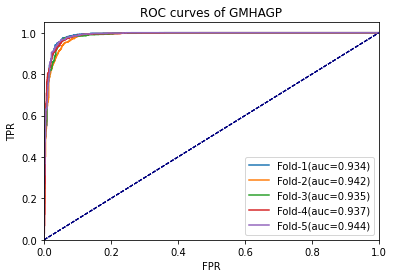

In [75]:
for i in range(len(aucs)):
    plt.plot(fpr_list[i],tpr_list[i],label="Fold-"+str(i+1)+"(auc="+str(round(aucs[i],3))+")")
    plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
    plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([0, 1.0])
plt.ylim([0, 1.05])
plt.title('ROC curves of GMHAGP')
plt.savefig('./data/nl_ROC.svg',dpi=300)
plt.show()